### test for plotting pft level data on h1 files
Created by Will Wieder
Improved by Orhan Eroglu
March 2025

In [1]:
import os, sys
import shutil
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import xesmf as xe

# Helpful for plotting only
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import uxarray as ux  #need npl 2024a or later
import geoviews.feature as gf

#sys.path.append('/glade/u/home/wwieder/python/adf/lib/plotting_functions.py')

In [2]:
# Load datataset  
# TODO, develop function for this too
gppfile='/glade/derecho/scratch/wwieder/ADF/b.e30_beta04.BLT1850.ne30_t232_wgx3.121/climo/b.e30_beta04.BLT1850.ne30_t232_wgx3.121_GPP_climo.nc'
laih1file='/glade/derecho/scratch/wwieder/ctsm53n04ctsm52028_ne30pg3t232_hist.clm2.h1.TLAI.1860s.nc'
case = 'ctsm53n04ctsm52028_ne30pg3t232_hist'

mesh0 = '/glade/campaign/cesm/cesmdata/inputdata/share/meshes/ne30pg3_ESMFmesh_cdf5_c20211018.nc'

#ux file for plotting
uxds0 = ux.open_dataset(mesh0, gppfile).max('time')
uxds1 = ux.open_dataset(mesh0, laih1file).max('time')

In [3]:
# select a single PFT
## TODO this step is kind of a memory hog
## OERO NOTE: Almost no memory increase after this code's execution in this UXarray's case
npft=16
var='TLAI'

for i in range(1, npft):
    print('starting pft ' + str(i))
    ## OERO NOTE: UxDataset.where() below had an issue that we've fixed last week and the fixed 
    ## version is scheduled for release v2025.03.0 today. If you want to check this code out sooner
    ## than the release, run the following command in your conda environment to install UXarray from 
    ## the GitHub repository:
    ## pip install git+https://github.com/UXARRAY/uxarray.git
    temp = uxds1.where(uxds1.pfts1d_itype_veg==i, drop=True)
    # TODO, this should be time evolving, but not currently doen
    # Rename coord, since the pft dimension is not meaningful
    temp= temp.rename({'pft': 'n_face'})
    
    # assign values from pfts1d_ixy to n_face
    temp['n_face'] = temp.pfts1d_ixy.astype(int)
    temp.assign_coords({"npft": i})
    # combine along PFT variable
    if i == 1:
        uxdsOut = temp
    else:
        uxdsOut = xr.concat([uxdsOut, temp], dim="npft")

## UXARRAY TODO: After Xarray.concatenate call on UXarray objects, the Grid object, ``uxgrid``
## is being dropped. To get it back, I had to reassign. While being able to run Xarray's builtin 
## function on UXarray objects directly was convenient, and adding this Grid back is not a big deal
## we may still want to explore an UXarray solution for concatenate
uxdsOut.uxgrid = temp.uxgrid
uxdsOut

starting pft 1
starting pft 2
starting pft 3
starting pft 4
starting pft 5
starting pft 6
starting pft 7
starting pft 8
starting pft 9
starting pft 10
starting pft 11
starting pft 12
starting pft 13
starting pft 14
starting pft 15


<xarray.UxDataset> Size: 32MB
Dimensions:             (npft: 15, hist_interval: 2, n_face: 15962)
Coordinates:
  * n_face              (n_face) int64 128kB 737 738 745 ... 48598 48599 48600
Dimensions without coordinates: npft, hist_interval
Data variables: (12/16)
    time_bounds         (npft, hist_interval, n_face) object 4MB 1869-12-01 0...
    pfts1d_lon          (npft, n_face) float64 2MB 19.5 20.5 ... 136.0 135.0
    pfts1d_lat          (npft, n_face) float64 2MB -34.9 -34.73 ... 36.2 35.74
    pfts1d_ixy          (npft, n_face) float64 2MB 737.0 738.0 ... 4.86e+04
    pfts1d_jxy          (npft, n_face) float64 2MB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    pfts1d_gi           (npft, n_face) float64 2MB 1.0 2.0 ... 1.596e+04
    ...                  ...
    pfts1d_wtcol        (npft, n_face) float64 2MB 0.0 0.0 0.0 ... 1.0 1.0 1.0
    pfts1d_itype_veg    (npft, n_face) float64 2MB 1.0 1.0 1.0 ... 15.0 15.0
    pfts1d_itype_col    (npft, n_face) float64 2MB 1.0 1.0 1.0 ... 215.0 215.0
    pfts1d_itype_lunit  (npft, n_face) float64 2MB 1.0 1.0 1.0 ... 2.0 2.0 2.0
    pfts1d_active       (npft, n_face) float64 2MB nan nan nan ... nan nan nan
    TLAI                (npft, n_face) float32 958kB nan nan nan ... nan nan nan

In [4]:
# align subset pft output with plotting data array
target = uxds0.GPP
n_face_coords = np.arange(1,(uxds1.pfts1d_ixy.max().astype(int)+1))
target = target.assign_coords({'n_face': ('n_face', n_face_coords)})
target

<xarray.UxDataArray 'GPP' (n_face: 48600)> Size: 194kB
array([          nan,           nan,           nan, ..., 7.3058734e-05,
       7.4361727e-05, 8.8926041e-05], dtype=float32)
Coordinates:
  * n_face   (n_face) int64 389kB 1 2 3 4 5 6 ... 48596 48597 48598 48599 48600

In [5]:
# Now align the land only output on the target (full) grid
uxdsOut_align, target = xr.align(uxdsOut, target, join="right")

In [6]:
# Copy  pft indexed data back to the h0 file
# This allows us to use area and landfrac on the same dataset 
# Used to calculate weighted sums of LAI and livefrac
uxds0_plot = uxds0
uxds0_plot[var] = uxdsOut_align[var]
uxds0_plot['pfts1d_wtgcell'] = uxdsOut_align['pfts1d_wtgcell']
uxds0_plot


<xarray.UxDataset> Size: 10MB
Dimensions:         (n_face: 48600, npft: 15)
Coordinates:
  * n_face          (n_face) int64 389kB 1 2 3 4 5 ... 48597 48598 48599 48600
Dimensions without coordinates: npft
Data variables:
    GPP             (n_face) float32 194kB nan nan nan ... 7.436e-05 8.893e-05
    area            (n_face) float32 194kB nan nan nan ... 9.519e+03 9.519e+03
    landfrac        (n_face) float32 194kB nan nan nan ... 0.6608 0.2991 0.07713
    landmask        (n_face) float64 389kB nan nan nan nan ... nan 1.0 1.0 1.0
    TLAI            (npft, n_face) float32 3MB nan nan nan nan ... nan nan nan
    pfts1d_wtgcell  (npft, n_face) float64 6MB nan nan nan nan ... 0.0 0.0 0.0

In [7]:
pft_names = ['NET Temperate', 'NET Boreal', 'NDT Boreal',
             'BET Tropical', 'BET Temperate', 'BDT Tropical',
             'BDT Temperate', 'BDT Boreal', 'BES Temperate',
             'BDS Temperate', 'BDS Boreal', 'C3 Grass Arctic',
             'C3 Grass', 'C4 Grass', 'UCrop UIrr']

-- wrote pft TLAI figure --


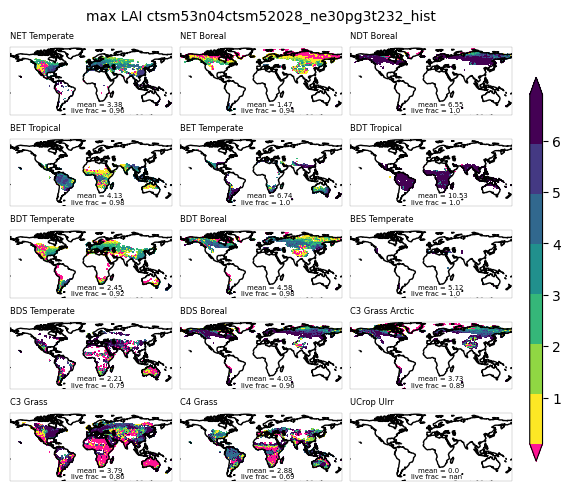

In [8]:
transform = ccrs.PlateCarree()
proj = ccrs.PlateCarree()
cmap = plt.cm.viridis_r
cmap.set_under(color='deeppink')
cmap = cmap.resampled(7)
levels = [0.1, 1, 2, 3, 4, 5, 6,7]

# create figure object
fig, axs = plt.subplots(5,3,
    facecolor="w",
    constrained_layout=True,
    subplot_kw=dict(projection=proj) )

axs=axs.flatten()

# Loop over pfts
for i in range((npft-1)):
    ac = uxds0_plot[var].isel(npft=i).to_polycollection(projection=proj)
    ac.set_cmap(cmap)
    ac.set_antialiased(False)
    ac.set_transform(transform)
    ac.set_clim(vmin=0.1,vmax=6.9)
    axs[i].add_collection(ac)

    #Titles, statistics
    wgts = uxds0_plot.area * uxds0_plot.landfrac * uxds0_plot.pfts1d_wtgcell.isel(npft=i)
    wgts = wgts / wgts.sum()
    mean = str(np.round((uxds0_plot[var].isel(npft=i)*wgts).sum().values,2))
    dead = ((uxds0_plot[var].isel(npft=i)<0.1)*wgts).sum()
    live = ((uxds0_plot[var].isel(npft=i)>0.1)*wgts).sum()
    livefrac = str(np.round((live/(live+dead)).values,2))
    axs[i].set_title(pft_names[i], loc='left',size=6)
    axs[i].text(-30, -45,'mean = '+ mean, fontsize=5)
    axs[i].text(-45, -60,'live frac = '+livefrac,fontsize=5)

for a in axs:
    a.coastlines()
    a.set_global()
    a.spines['geo'].set_linewidth(0.1) #cartopy's recommended method
    a.set_extent([-180, 180, -65, 86])

#fig.subplots_adjust(right=0.97)
cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.8])
fig.colorbar(ac, cax=cbar_ax, pad=0.05, shrink=0.8, aspect=40,
            extend='both')
fig.suptitle("max LAI "+ case,size='medium')
fig.set_layout_engine("compressed")

fig.savefig('h1_test', bbox_inches='tight', dpi=300)
print('-- wrote pft '+var+' figure --')
